# Data Pre-Processing and Analytics (Part 1)
This notebook demonstrates basic methods of data pre-processing and analytics. It also demonstrates that a volatile 12% is better than a stable 3%, given that you have the ability to react with equanimity to normal vicissitudes and worldly outcomes.

In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import requests

load_dotenv()
api_key = os.getenv('fmp_api_key')
url_base = "https://financialmodelingprep.com/stable/"

constituents = requests.get(url=f"{url_base}sp500-constituent", params={'apikey': api_key}).json()
df_constituents = pd.DataFrame(constituents)
df_constituents.head()

,symbol,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded
0,IBKR,Interactive Brokers Group,Financial Services,Investment - Banking & Investment Services,"Greenwich, CT",2025-08-28,0001381197,1982
1,XYZ,"Block, Inc.",Technology,Software - Infrastructure,"Oakland, California",2025-07-23,0001512673,2009
2,TTD,"The Trade Desk, Inc.",Technology,Software - Application,"Ventura, California",2025-07-18,0001671933,2009
3,DDOG,Datadog,Technology,Software - Application,"New York City, New York",2025-07-09,0001561550,2010
4,COIN,Coinbase Global,Financial Services,Financial - Data & Stock Exchanges,"Wilmington, Delaware",2025-05-19,0001679788,2012


In [2]:
from us import states as us_states

df_constituents['dateFirstAdded'] = pd.to_datetime(df_constituents['dateFirstAdded'])
df_constituents['yearAdded'] = df_constituents['dateFirstAdded'].dt.year
df_constituents['headQuarterState'] = df_constituents['headQuarter'].str.split(',').str[1].str.strip()
us_abbr_to_name = {s.abbr: s.name for s in us_states.STATES + [us_states.DC]}
df_constituents['headQuarterState'] = df_constituents['headQuarterState'].apply(lambda x: us_abbr_to_name.get(x, x))
df_constituents = df_constituents.drop(columns=['founded','dateFirstAdded', 'cik', 'headQuarter'])
df_constituents = df_constituents.rename(columns={'symbol': 'ticker','subSector': 'subsector','yearAdded': 'year_added','headQuarterState': 'headquarter_state'})
df_constituents.to_csv("data/sp500_constituents.csv", index=False)
df_constituents.head()

,ticker,name,sector,subsector,year_added,headquarter_state
0,IBKR,Interactive Brokers Group,Financial Services,Investment - Banking & Investment Services,2025,Connecticut
1,XYZ,"Block, Inc.",Technology,Software - Infrastructure,2025,California
2,TTD,"The Trade Desk, Inc.",Technology,Software - Application,2025,California
3,DDOG,Datadog,Technology,Software - Application,2025,New York
4,COIN,Coinbase Global,Financial Services,Financial - Data & Stock Exchanges,2025,Delaware


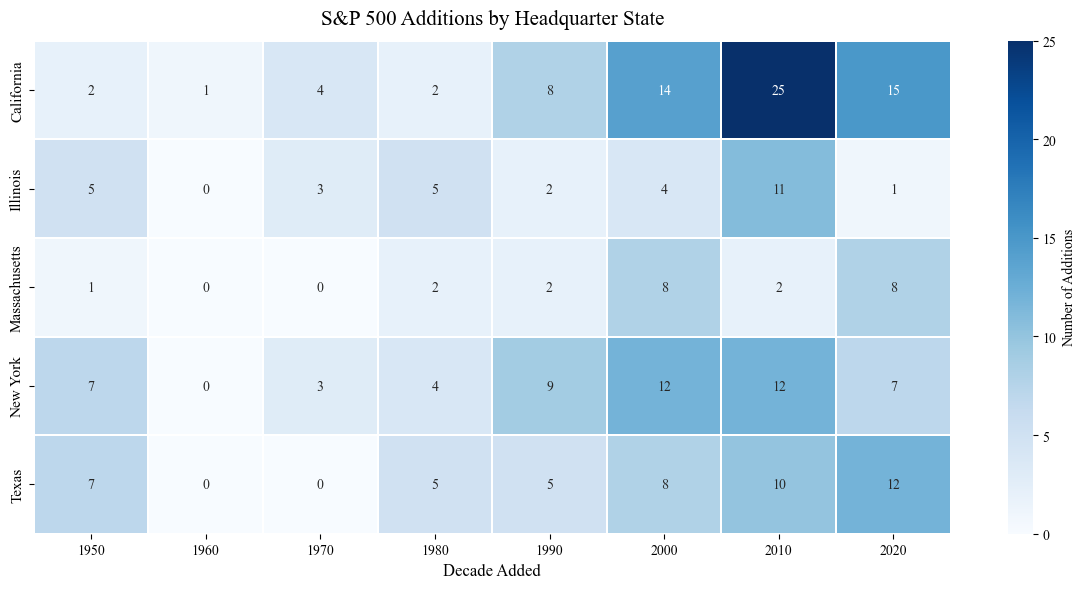

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

common_states = df_constituents['headquarter_state'].value_counts().head(5).index
common_states_decade_counts = (
    df_constituents[df_constituents['headquarter_state'].isin(common_states)]
    .assign(decade=(df_constituents['year_added']//10)*10)
    .pivot_table(index="headquarter_state", columns="decade", values="ticker", aggfunc="count", fill_value=0)
)

mpl.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12,6))
sns.heatmap(common_states_decade_counts, cmap="Blues", annot=True, linewidths=0.1, cbar_kws={'label': 'Number of Additions'})
plt.title("S&P 500 Additions by Headquarter State", fontsize=15, pad=12)
plt.xlabel("Decade Added", fontsize=12)
plt.ylabel("")
plt.xticks(rotation=0)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

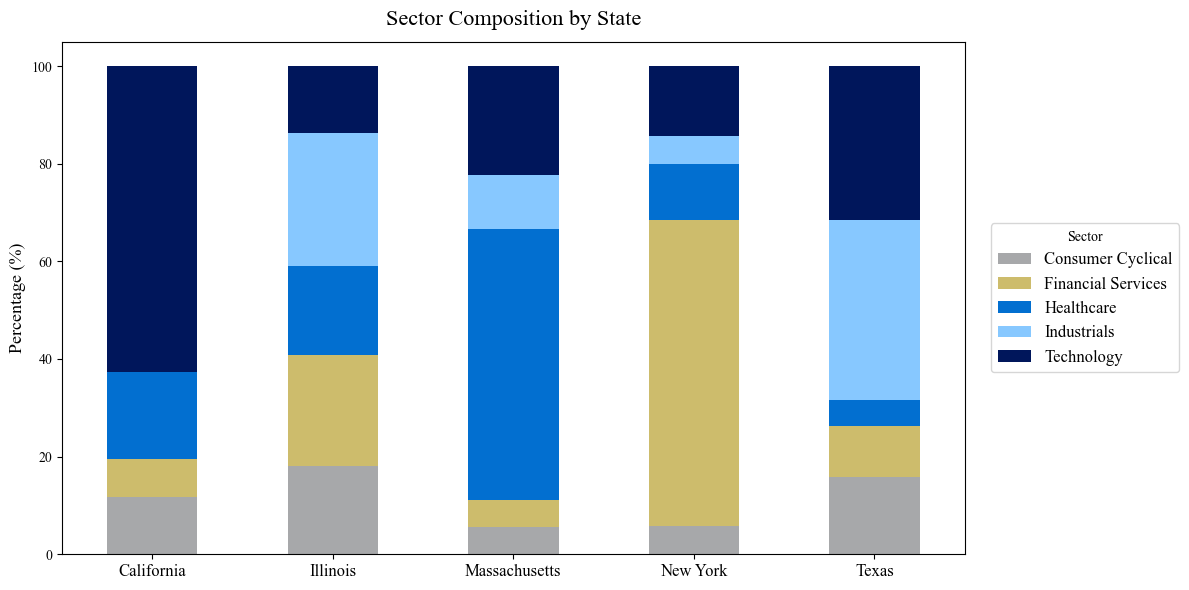

In [4]:
common_sectors = df_constituents['sector'].value_counts().head(5).index
common_states_sector_counts = (
    df_constituents[df_constituents['headquarter_state'].isin(common_states) & df_constituents['sector'].isin(common_sectors)]
    .pivot_table(index="headquarter_state", columns="sector", values="ticker", aggfunc="count", fill_value=0)
)
common_states_sector_pct = common_states_sector_counts.div(common_states_sector_counts.sum(axis=1), axis=0) * 100

custom_colors = ['#a7a8aa', '#cdbc6c', '#026fd0', '#87c8ff', '#00165b']
plt.figure(figsize=(12,6))
common_states_sector_pct.plot(kind="bar",stacked=True,color=custom_colors,ax=plt.gca())
plt.title("Sector Composition by State", fontsize=16, pad=12)
plt.xlabel("")
plt.ylabel("Percentage (%)", fontsize=13)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title="Sector", bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=12)
plt.tight_layout()
plt.show()

In [5]:
ENDPOINTS = [
    {"name": "income_statement","url": f"{url_base}income-statement","params": {"period": "annual", "limit": 100}},
    {"name": "balance_sheet","url": f"{url_base}balance-sheet-statement","params": {"period": "annual", "limit": 100}},
    {"name": "cashflow_statement","url": f"{url_base}cash-flow-statement","params": {"period": "annual", "limit": 100}},
    {"name": "financial_metrics","url": f"{url_base}key-metrics","params": {"period": "annual", "limit": 100}},
    {"name": "financial_ratios","url": f"{url_base}ratios","params": {"period": "annual", "limit": 100}},
    {"name": "income_statement_growth","url": f"{url_base}income-statement-growth","params": {"period": "annual", "limit": 100}},
    {"name": "balance_sheet_growth","url": f"{url_base}balance-sheet-statement-growth","params": {"period": "annual", "limit": 100}},
    {"name": "cashflow_statement_growth","url": f"{url_base}cash-flow-statement-growth","params": {"period": "annual", "limit": 100}},
    {"name": "dividend_adjusted_prices","url": f"{url_base}historical-price-eod/dividend-adjusted","params": {"from": "2000-01-01", "to": "2025-01-01"}}
]

index_data = requests.get(url=f"{url_base}historical-price-eod/dividend-adjusted", params={"from": "1995-01-01", "to": "2025-01-01", "symbol": "SPY", "apikey": api_key}).json()
df_index = pd.DataFrame(index_data)

dataset = {}

for ep in ENDPOINTS:
    temp = []
    print(f"Retrieving {ep['name']} data")
    for ticker in df_constituents["ticker"]:
        params = {**ep["params"], "symbol": ticker, "apikey": api_key}
        data = requests.get(url=ep["url"], params=params).json()
        if data:
            df_temp = pd.DataFrame(data)
            temp.append(df_temp)
    dataset[ep["name"]] = pd.concat(temp, ignore_index=True) if temp else pd.DataFrame()

df_index.to_csv("data/index_data.csv", index=False)
for name, df in dataset.items():
    path = f"data/{name}.csv"
    df.to_csv(path, index=False)
    print(f"Saved {name} -> {path}")

Retrieving income_statement data
Retrieving balance_sheet data
Retrieving cashflow_statement data
Retrieving financial_metrics data


/var/folders/x2/36b44cxs7fxf1dzfvnf_byr00000gn/T/ipykernel_55627/823731150.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset[ep["name"]] = pd.concat(temp, ignore_index=True) if temp else pd.DataFrame()


Retrieving financial_ratios data
Retrieving income_statement_growth data
Retrieving balance_sheet_growth data
Retrieving cashflow_statement_growth data
Retrieving dividend_adjusted_prices data
Saved income_statement -> data/income_statement.csv
Saved balance_sheet -> data/balance_sheet.csv
Saved cashflow_statement -> data/cashflow_statement.csv
Saved financial_metrics -> data/financial_metrics.csv
Saved financial_ratios -> data/financial_ratios.csv
Saved income_statement_growth -> data/income_statement_growth.csv
Saved balance_sheet_growth -> data/balance_sheet_growth.csv
Saved cashflow_statement_growth -> data/cashflow_statement_growth.csv
Saved dividend_adjusted_prices -> data/dividend_adjusted_prices.csv


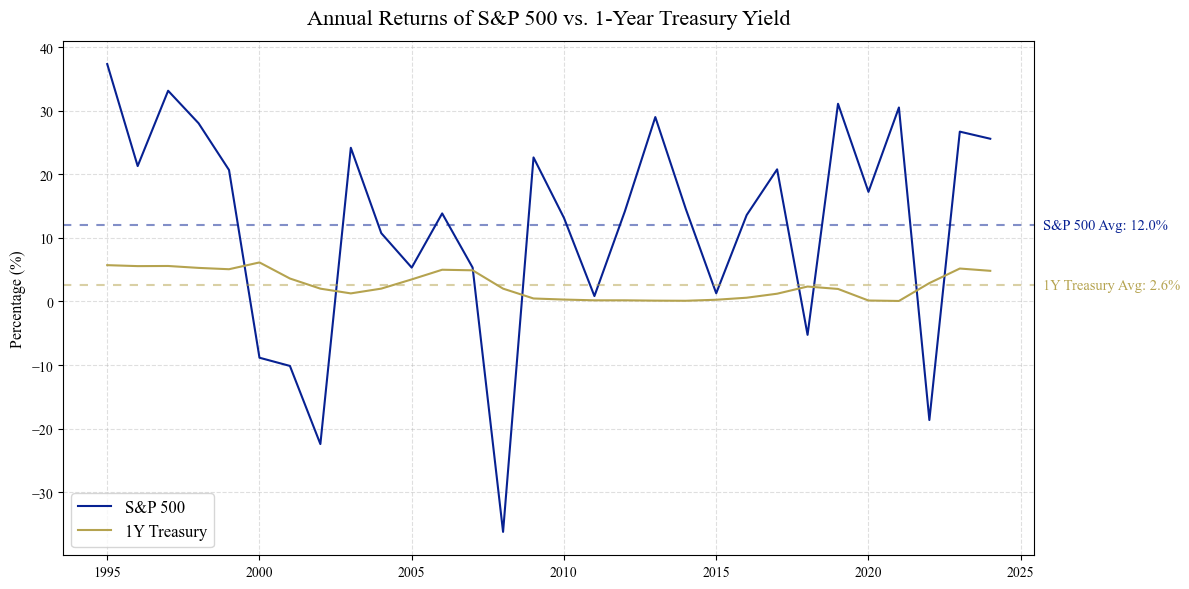

In [6]:
df_index["date"] = pd.to_datetime(df_index["date"])
df_index["year"] = df_index["date"].dt.year
df_index["total_return_pct"] = ((df_index["adjClose"] / df_index["adjClose"].iloc[-1]) - 1) * 100
df_index.to_csv("data/index_data.csv", index=False)

df_index_1yr_returns = (
    df_index
    .sort_values("date")
    .groupby("year")["adjClose"]
    .agg(first="first", last="last")
    .eval("pct_return = (last / first - 1) * 100")[["pct_return"]]
    .reset_index()
)
df_index_1yr_returns.to_csv("data/index_1yr_returns.csv", index=False)
treasury_rates = requests.get(url=f"{url_base}treasury-rates", params={"from": "1995-01-01", "to": "2025-01-01", "apikey": api_key}).json()
df_treasury = pd.DataFrame(treasury_rates)
df_treasury["date"] = pd.to_datetime(df_treasury["date"])
df_treasury["year"] = df_treasury["date"].dt.year
df_1yr_treasury = df_treasury[["year", "year1"]]
df_1yr_treasury_median = (df_1yr_treasury.groupby("year", as_index=False).median(numeric_only=True).rename(columns={"year1": "1yr_yield"}))
avg_sp_return = df_index_1yr_returns["pct_return"].mean()
avg_treasury_yield = df_1yr_treasury_median["1yr_yield"].mean()
mpl.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_index_1yr_returns, x="year", y="pct_return",color="#072192", label="S&P 500")
sns.lineplot(data=df_1yr_treasury_median, x="year", y="1yr_yield",color="#b5a34f", label="1Y Treasury")
plt.title("Annual Returns of S&P 500 vs. 1-Year Treasury Yield", fontsize=16, pad=12)
plt.xlabel("")
plt.ylabel("Percentage (%)", fontsize=11.5)
plt.legend(fontsize=12, loc="lower left")
plt.grid(True, linestyle="--", alpha=0.4)
ax = plt.gca()
ax.axhline(avg_sp_return, linestyle=(0, (4, 4)), color="#072192", alpha=0.5)
ax.axhline(avg_treasury_yield, linestyle=(0, (4, 4)), color="#b5a34f", alpha=0.51)
xmax = ax.get_xlim()[1]
for y, color, label in [(avg_sp_return, "#072192", "S&P 500 Avg"),(avg_treasury_yield, "#b5a34f", "1Y Treasury Avg")]:
    ax.annotate(
        f"{label}: {y:.1f}%",
        xy=(xmax, y), xycoords=("data", "data"),
        xytext=(6, 0), textcoords="offset points",
        ha="left", va="center", fontsize=10.5, color=color)
plt.tight_layout()
plt.show()

> *A volatile 12% is better than a stable 3%, given that you have the ability to react with equanimity to normal vicissitudes and worldly outcomes. This, however, does not mean that the index is guaranteed to produce such results indefinitely.*